# Single-Objective Optimisation in Ms. Pac-Man using a Genetic Algorithm

This notebook displays the results from the implementation of a simple genetic algorithm to evolve AI agents for Ms. Pac-Man. The objective is to maximise the score achieved by the agent in the game environment using the OpenAI Gymnasium framework.

In [1]:
# Import required libraries
import gymnasium as gym
import ale_py
from gymnasium.wrappers import RecordVideo, RecordEpisodeStatistics
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import os
import time
from scipy import stats

# Load the final results
with open('ms_pacman_ga_results_final.pkl', 'rb') as f: # replace file name with partially complete run by x generations if necessary
    results = pickle.load(f)
    
# Extract data from results
generation_data = results['generation_data']
best_individuals = results['best_individuals'] # best of last generation
top_10_individuals = results['top_10_individuals']
best_fitness_values = results['best_fitness_values'] # best of last generation
top_10_fitness_values = results['top_10_fitness_values']

best_indv = results['best_ind'] #orig from tools
best_individual = results['best_individual']

generation_data
# best_indv
# best_individual

,Generation,Max Fitness,Avg Fitness,Avg Time Taken (s),Max Time Taken (s)
0,0,1750.0,286.35,19.248943,19.248943
1,1,1140.0,286.60,14.542980,29.085960
2,2,1070.0,307.20,13.054903,39.164708
3,3,1810.0,352.30,12.281597,49.126389
4,4,1840.0,404.90,11.909736,59.548681
...,...,...,...,...,...
995,995,4450.0,1924.90,13.514705,13460.646653
996,996,4420.0,1975.55,13.514973,13474.427714
997,997,4390.0,1910.75,13.515071,13488.041122
998,998,4990.0,2003.30,13.515384,13501.868624


# Performance metrics

In [2]:
# Performance Metrics

print("Performance metrics")

metrics = pd.DataFrame({
    'Metric': ['Best Fitness Score', 
               'Average Fitness Score', 
               'Final Generation', 
               'Total Training Time (hours)',
               'Fastest Time for Generation (s)', 
#                'Max Time per Generation (s)', 
               'Average Time per Generation (s)'],
    'Value': [
        generation_data['Max Fitness'].max(),
        generation_data['Avg Fitness'].mean(),
        generation_data['Generation'].max(),
        generation_data['Max Time Taken (s)'].max() / 3600,
        generation_data['Avg Time Taken (s)'].min(),
#         generation_data['Avg Time Taken (s)'][1:].mean(),  # Exclude first generation
#         generation_data['Avg Time Taken (s)'][5:].max(),  # Exclude first generation
        generation_data['Avg Time Taken (s)'].mean()  
    ]
})

metrics
# best_fitness_values

Performance metrics


,Metric,Value
0,Best Fitness Score,6830.000000
1,Average Fitness Score,1686.471850
2,Final Generation,999.000000
3,Total Training Time (hours),3.754392
4,Fastest Time for Generation (s),10.810533
5,Average Time per Generation (s),12.825227


# Training metrics

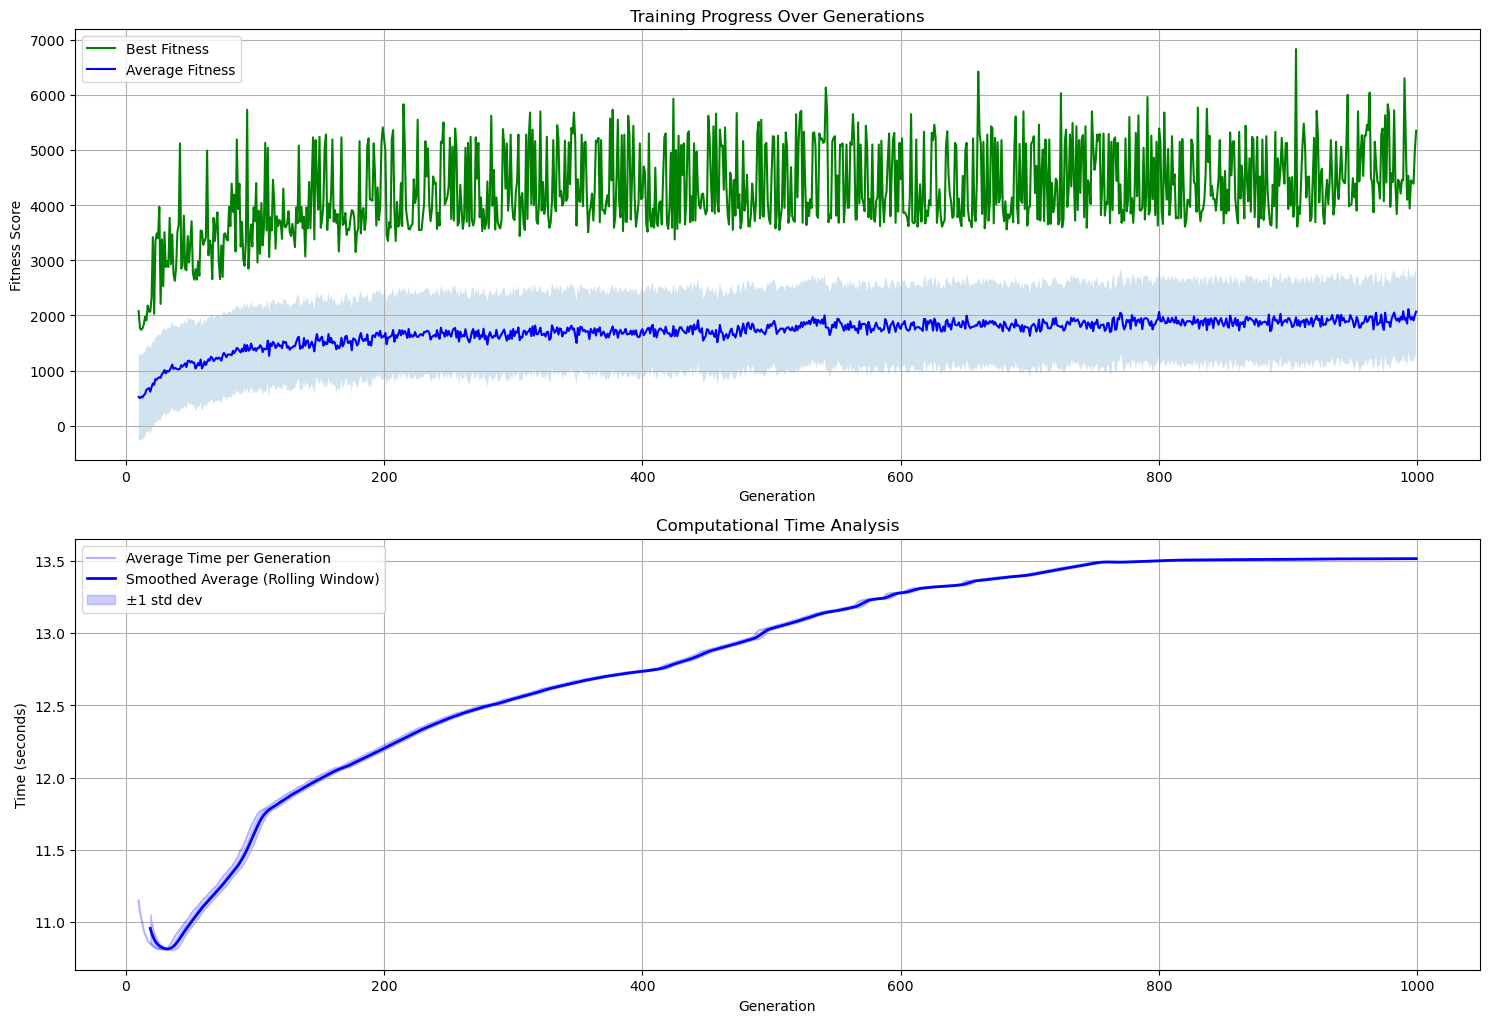

In [3]:
# Training metrics
plt.figure(figsize=(15, 15))

# Plot training progression
plt.subplot(3,1,1)

data = results['generation_data'][10:] # take out first 10 generations due to skew on time taken

plt.plot(data['Generation'], data['Max Fitness'], label='Best Fitness', color='green')
plt.plot(data['Generation'], data['Avg Fitness'], label='Average Fitness', color='blue')
plt.fill_between(data['Generation'], 
                 data['Avg Fitness'] - data['Max Fitness'].std(),
                 data['Avg Fitness'] + data['Max Fitness'].std(),
                 alpha=0.2)
plt.title('Training Progress Over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.legend()
plt.grid(True)

# Plot time metrics
plt.subplot(3,1,2)
try:
    # Calculate rolling statistics for smoother visualisation
    window_size = 10
    rolling_avg = data['Avg Time Taken (s)'].rolling(window=window_size).mean()
    rolling_std = data['Avg Time Taken (s)'].rolling(window=window_size).std()
    
    # Plot average time
    plt.plot(data['Generation'], data['Avg Time Taken (s)'], 
             label='Average Time per Generation', 
             color='blue', 
             alpha=0.3)  # Original data with transparency
    
    # Plot smoothed average
    plt.plot(data['Generation'], rolling_avg,
             label='Smoothed Average (Rolling Window)',
             color='blue',
             linewidth=2)
    
    # Add confidence interval
    plt.fill_between(data['Generation'],
                    rolling_avg - rolling_std,
                    rolling_avg + rolling_std,
                    alpha=0.2,
                    color='blue',
                    label='±1 std dev')
    
# #     # Add maximum time line
#     plt.plot(data['Generation'], data['Max Time Taken (s)'],
#              label='Maximum Time per Generation',
#              color='red',
#              alpha=0.5,
#              linestyle='--')

except Exception as e:
    print(f"Error plotting time metrics: {e}")
    print("\nData columns available:", data.columns)
    print("\nFirst few rows of time data:")
    print(data[['Generation', 'Avg Time Taken (s)', 'Max Time Taken (s)']].head())

plt.title('Computational Time Analysis')
plt.xlabel('Generation')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Convergence Analysis

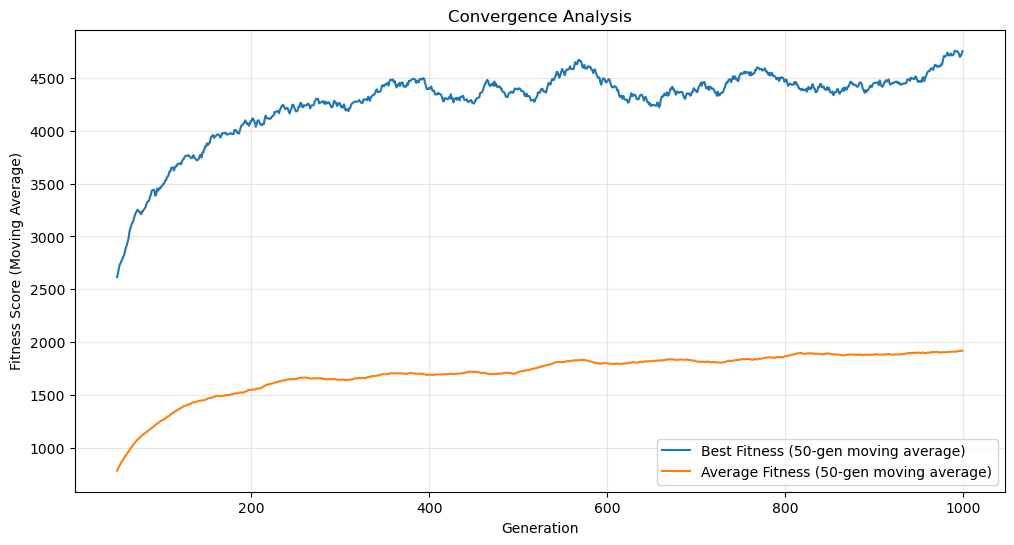

In [4]:
# Convergence Analysis
data = results['generation_data'] # include all generations
plt.figure(figsize=(12, 6))
rolling_window = 50
plt.plot(generation_data['Generation'], 
         generation_data['Max Fitness'].rolling(window=rolling_window).mean(), 
         label=f'Best Fitness ({rolling_window}-gen moving average)')
plt.plot(generation_data['Generation'], 
         generation_data['Avg Fitness'].rolling(window=rolling_window).mean(), 
         label=f'Average Fitness ({rolling_window}-gen moving average)')
plt.xlabel('Generation')
plt.ylabel('Fitness Score (Moving Average)')
plt.title('Convergence Analysis')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Training Time Analysis

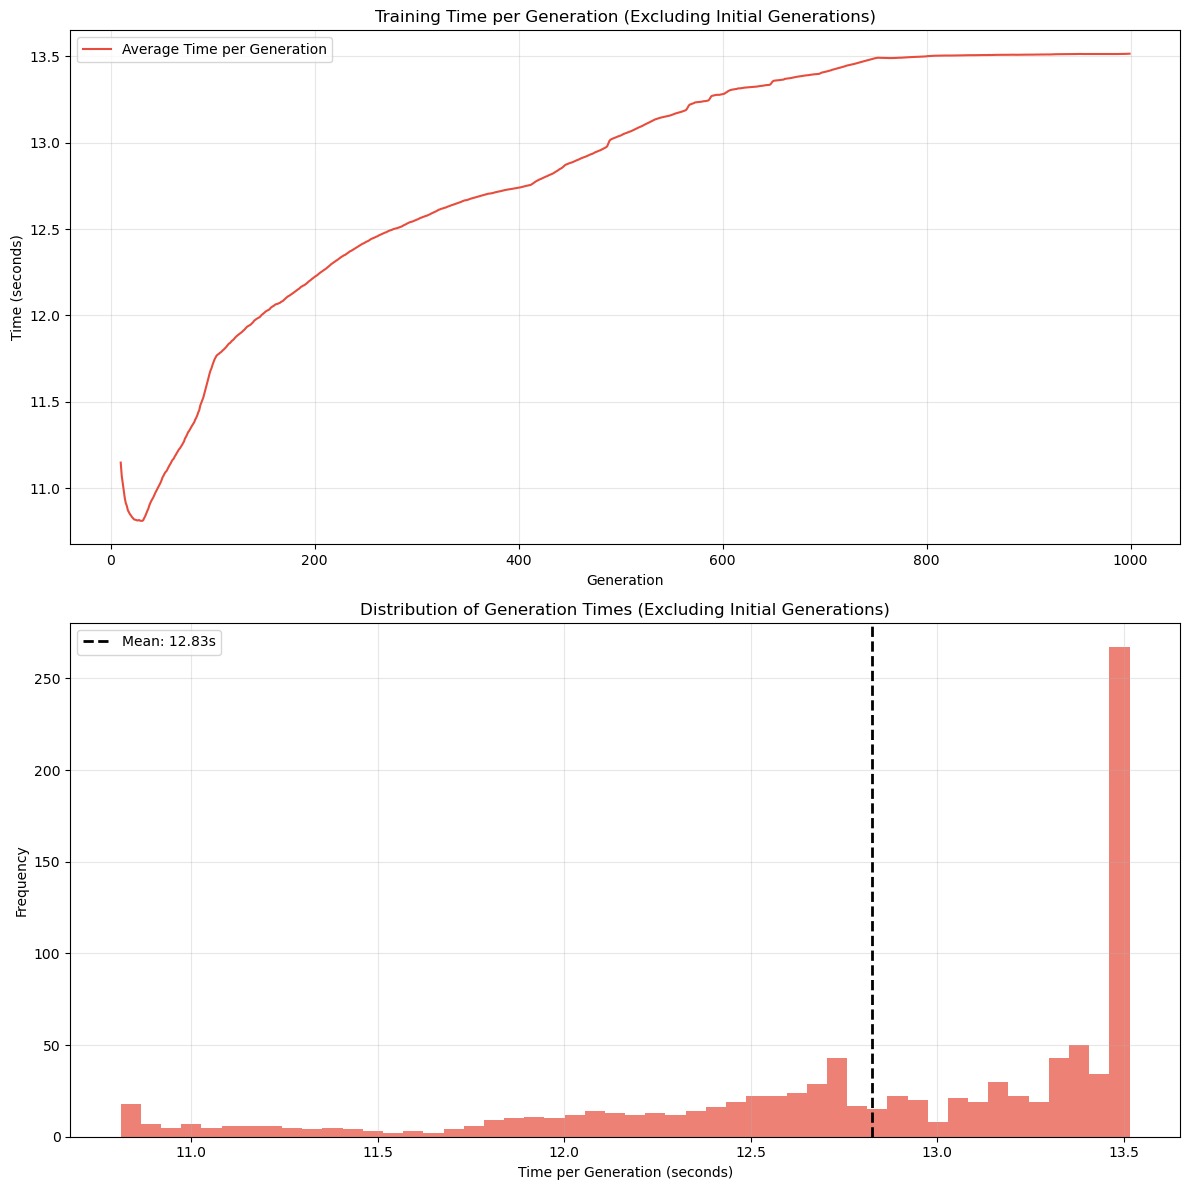

,Metric,Value
0,Initial Generation Time (s),19.248943
1,Average Time for Other Generations (s),12.825398
2,Median Time per Generation (s),13.054265
3,Standard Deviation of Time (s),0.732766
4,95th Percentile Time (s),13.513314


In [5]:
# Training Time Analysis (Multiple plots)
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Time per generation (excluding first 10 generation)
gen_times = generation_data['Avg Time Taken (s)'][10:]  # [10:] to exclude first 10 generations due to possible initial system resource allocation/environment loading 
axes[0].plot(generation_data['Generation'][10:], gen_times, 
            label='Average Time per Generation', color='#e74c3c')
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Training Time per Generation (Excluding Initial Generations)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Time distribution histogram
axes[1].hist(gen_times, bins=50, color='#e74c3c', alpha=0.7)
axes[1].axvline(gen_times.mean(), color='black', linestyle='dashed', linewidth=2, 
                label=f'Mean: {gen_times.mean():.2f}s')
axes[1].set_xlabel('Time per Generation (seconds)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Generation Times (Excluding Initial Generations)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print time statistics
time_stats = pd.DataFrame({
    'Metric': [
        'Initial Generation Time (s)',
        'Average Time for Other Generations (s)',
        'Median Time per Generation (s)',
        'Standard Deviation of Time (s)',
        '95th Percentile Time (s)'
    ],
    'Value': [
        generation_data['Avg Time Taken (s)'].iloc[0],
        gen_times.mean(),
        gen_times.median(),
        gen_times.std(),
        gen_times.quantile(0.95)
    ]
})

time_stats

# Algorithm performance

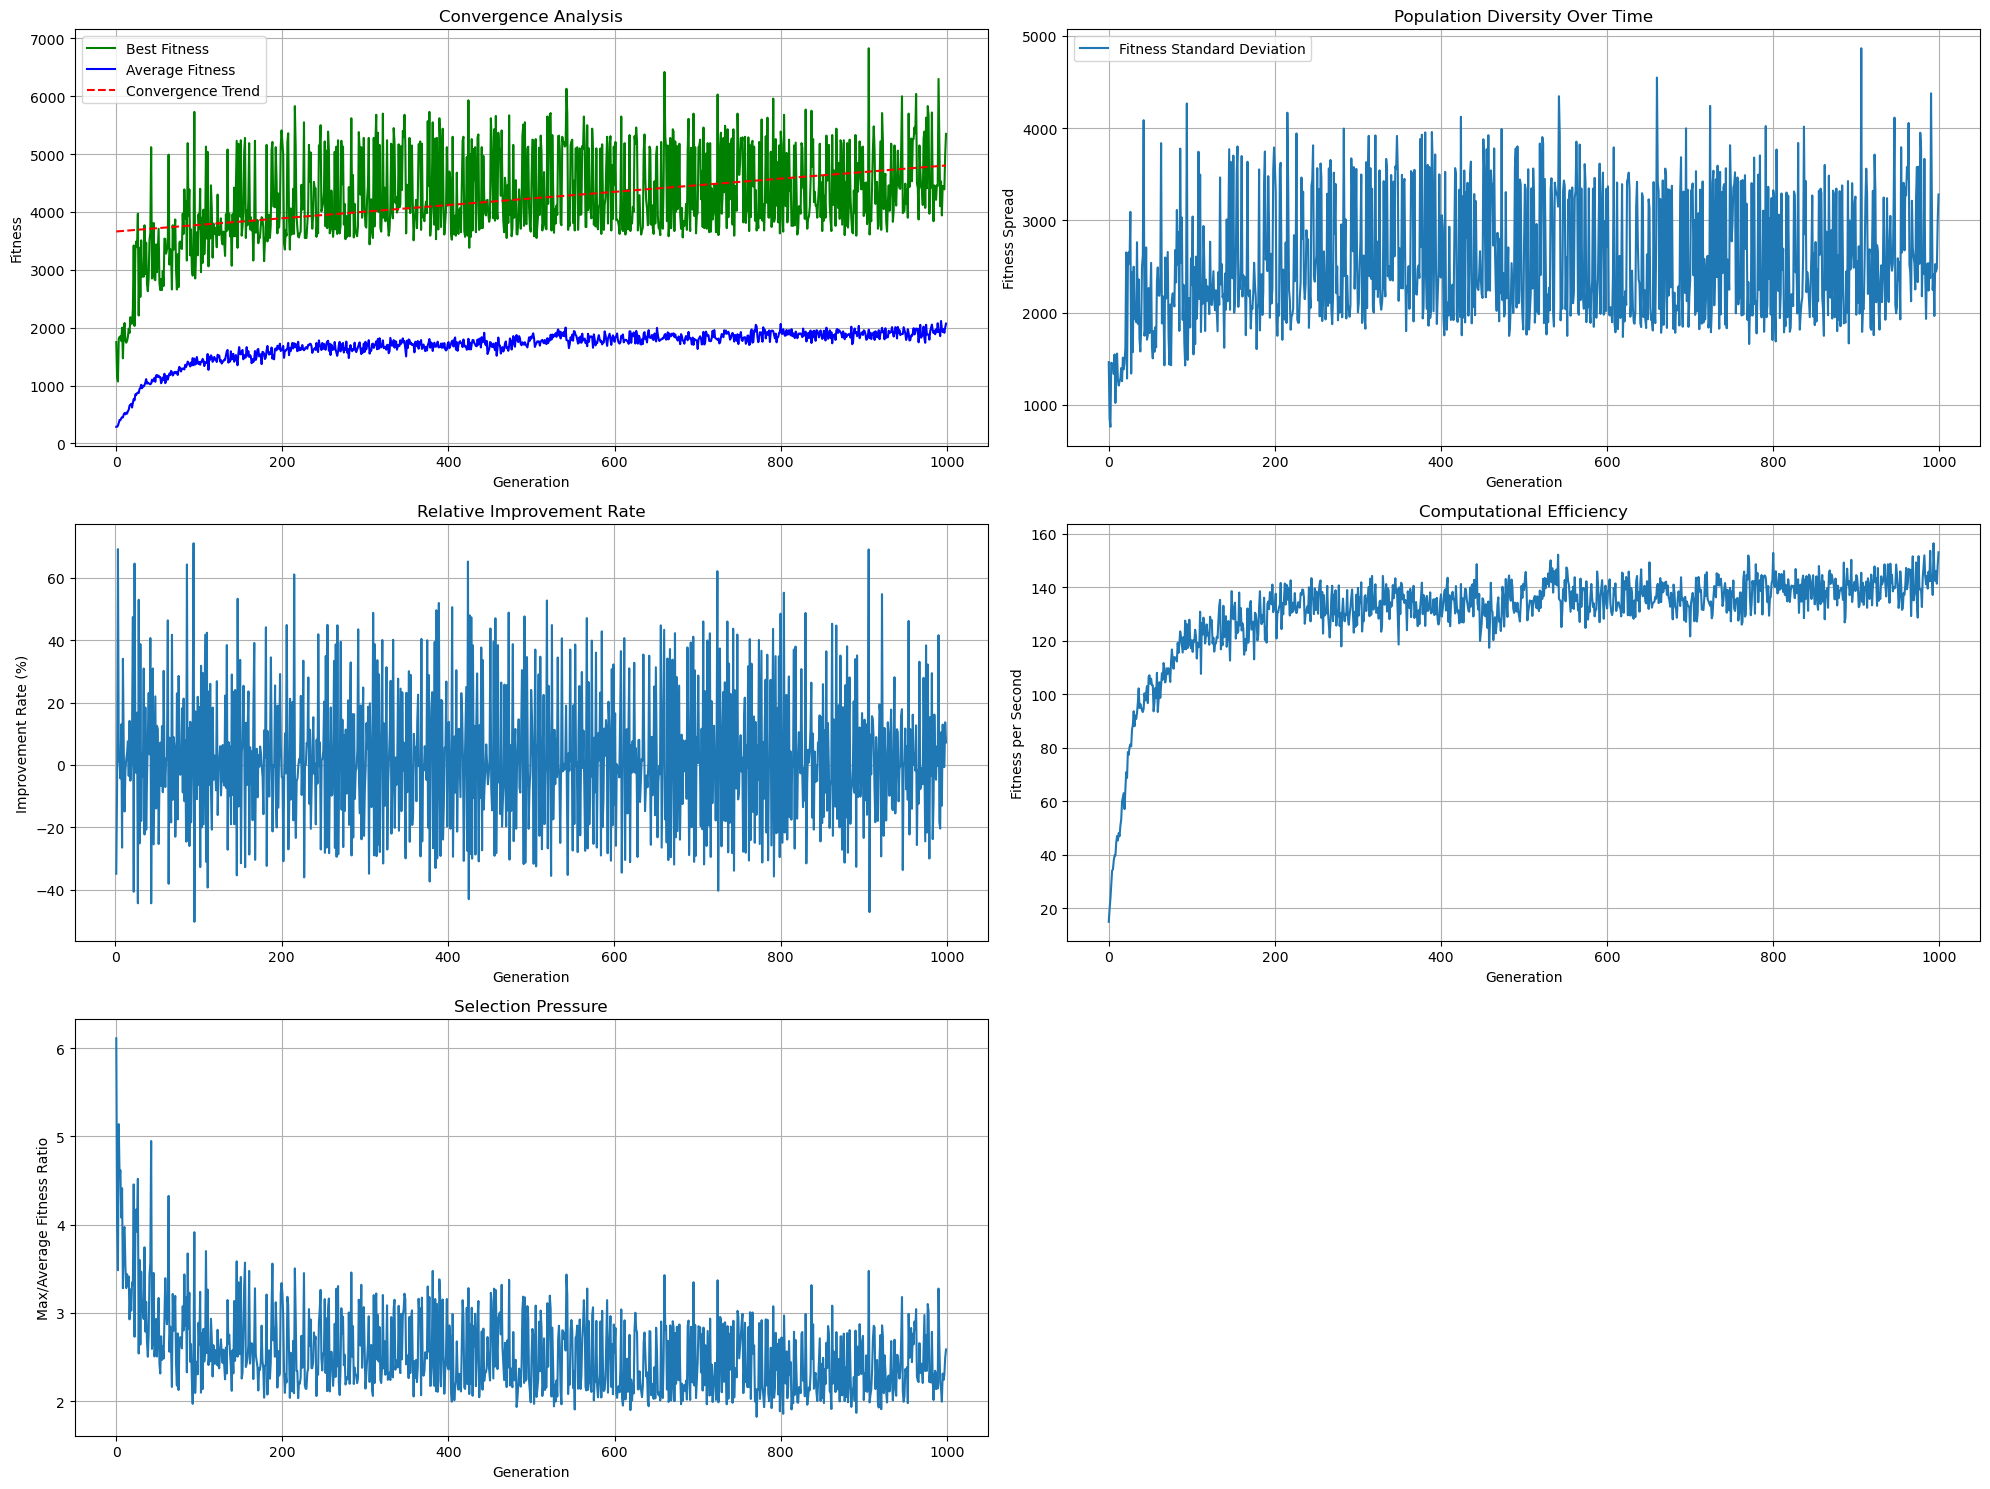


Genetic Algorithm Performance Metrics:

1. Convergence Analysis:
Initial fitness: 1750.00
Final fitness: 5350.00
Improvement: 205.71%
Convergence rate (slope): 1.1419
R-squared value: 0.1656

2. Population Diversity:
Initial diversity: 1463.65
Final diversity: 3280.15
Average diversity: 2546.91

3. Efficiency Metrics:
Average fitness per second: 130.89
Peak fitness per second: 156.52
Total computation time: 6610934.33 seconds

4. Convergence Speed:
Generations to reach 90% of max fitness: 42
Generation of best fitness: 906

5. Solution Quality:
Best fitness achieved: 6830.00
Fitness stability (last 10% of generations): 657.75
Average selection pressure: 2.55

6. Additional GA Metrics:
Approximate takeover time (generations): 905
Selection intensity: 2546.91
Genetic drift (variance in fitness changes): 878072.30


In [6]:
# Additional imports for visualisations
from scipy.stats import linregress
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pickle
warnings.filterwarnings('ignore')

def analyse_genetic_algorithm_performance(results):
    """Analyse the genetic algorithm's performance metrics"""
    
    # Extract generation data
    data = results['generation_data']
    logbook = results['logbook']
    
    plt.figure(figsize=(20, 15))
    
    # 1. Convergence Analysis
    plt.subplot(3, 2, 1)
    generations = data['Generation']
    max_fitness = data['Max Fitness']
    avg_fitness = data['Avg Fitness']
    
    # Plot convergence
    plt.plot(generations, max_fitness, label='Best Fitness', color='green')
    plt.plot(generations, avg_fitness, label='Average Fitness', color='blue')
    
    # Calculate convergence rate
    slope, intercept, r_value, p_value, std_err = linregress(generations, max_fitness)
    plt.plot(generations, slope * generations + intercept, '--', label='Convergence Trend', color='red')
    
    plt.title('Convergence Analysis')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.legend()
    plt.grid(True)
    
    # 2. Population Diversity
    plt.subplot(3, 2, 2)
    fitness_std = max_fitness - avg_fitness
    plt.plot(generations, fitness_std, label='Fitness Standard Deviation')
    plt.title('Population Diversity Over Time')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Spread')
    plt.legend()
    plt.grid(True)
    
    # 3. Improvement Rate
    plt.subplot(3, 2, 3)
    improvement_rate = np.diff(max_fitness.to_numpy()) / max_fitness.iloc[:-1].to_numpy() * 100
    plt.plot(generations.iloc[1:], improvement_rate)
    plt.title('Relative Improvement Rate')
    plt.xlabel('Generation')
    plt.ylabel('Improvement Rate (%)')
    plt.grid(True)
    
    # 4. Efficiency Metrics
    plt.subplot(3, 2, 4)
    efficiency = avg_fitness / data['Avg Time Taken (s)']
    plt.plot(generations, efficiency)
    plt.title('Computational Efficiency')
    plt.xlabel('Generation')
    plt.ylabel('Fitness per Second')
    plt.grid(True)
    
    # 5. Selection Pressure
    plt.subplot(3, 2, 5)
    selection_pressure = max_fitness / avg_fitness
    plt.plot(generations, selection_pressure)
    plt.title('Selection Pressure')
    plt.xlabel('Generation')
    plt.ylabel('Max/Average Fitness Ratio')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed statistics
    print("\nGenetic Algorithm Performance Metrics:")
    
    # 1. Convergence Statistics
    print("\n1. Convergence Analysis:")
    print(f"Initial fitness: {max_fitness.iloc[0]:.2f}")
    print(f"Final fitness: {max_fitness.iloc[-1]:.2f}")
    print(f"Improvement: {((max_fitness.iloc[-1] - max_fitness.iloc[0]) / max_fitness.iloc[0] * 100):.2f}%")
    print(f"Convergence rate (slope): {slope:.4f}")
    print(f"R-squared value: {r_value**2:.4f}")
    
    # 2. Population Diversity Statistics
    print("\n2. Population Diversity:")
    print(f"Initial diversity: {fitness_std.iloc[0]:.2f}")
    print(f"Final diversity: {fitness_std.iloc[-1]:.2f}")
    print(f"Average diversity: {np.mean(fitness_std):.2f}")
    
    # 3. Efficiency Metrics
    print("\n3. Efficiency Metrics:")
    print(f"Average fitness per second: {np.mean(efficiency):.2f}")
    print(f"Peak fitness per second: {np.max(efficiency):.2f}")
    print(f"Total computation time: {data['Max Time Taken (s)'].sum():.2f} seconds")
    
    # 4. Convergence Speed
    generations_to_90_percent = None
    max_possible_fitness = max_fitness.iloc[-1]
    threshold = 0.9 * max_possible_fitness
    for gen, fit in enumerate(max_fitness):
        if fit >= threshold:
            generations_to_90_percent = gen
            break
    
    print("\n4. Convergence Speed:")
    if generations_to_90_percent is not None:
        print(f"Generations to reach 90% of max fitness: {generations_to_90_percent}")
    print(f"Generation of best fitness: {max_fitness.idxmax()}")
    
    # 5. Solution Quality Metrics
    print("\n5. Solution Quality:")
    print(f"Best fitness achieved: {max_fitness.max():.2f}")
    last_10_percent = max_fitness.iloc[int(0.9*len(max_fitness)):]
    print(f"Fitness stability (last 10% of generations): {last_10_percent.std():.2f}")
    print(f"Average selection pressure: {np.mean(selection_pressure):.2f}")
    
    # 6. Calculate additional GA-specific metrics
    def calculate_takeover_time():
        """Calculate approximate takeover time"""
        fitness_diff = np.diff(max_fitness.to_numpy())
        max_diff = np.max(fitness_diff)
        return np.where(fitness_diff == max_diff)[0][0]
    
    print("\n6. Additional GA Metrics:")
    print(f"Approximate takeover time (generations): {calculate_takeover_time()}")
    print(f"Selection intensity: {np.mean(max_fitness - avg_fitness):.2f}")
    print(f"Genetic drift (variance in fitness changes): {np.var(np.diff(max_fitness.to_numpy())):.2f}")
    
    # Save metrics to file
    metrics = {
        'convergence_rate': slope,
        'r_squared': r_value**2,
        'final_diversity': fitness_std.iloc[-1],
        'avg_efficiency': np.mean(efficiency),
        'generations_to_90_percent': generations_to_90_percent,
        'best_fitness': max_fitness.max(),
        'takeover_time': calculate_takeover_time(),
        'selection_intensity': np.mean(max_fitness - avg_fitness),
        'genetic_drift': np.var(np.diff(max_fitness.to_numpy()))
    }
    
    with open('ga_performance_metrics.pkl', 'wb') as f:
        pickle.dump(metrics, f)
    
    return metrics

# Run the analysis
ga_metrics = analyse_genetic_algorithm_performance(results)

# Best solutions analysis

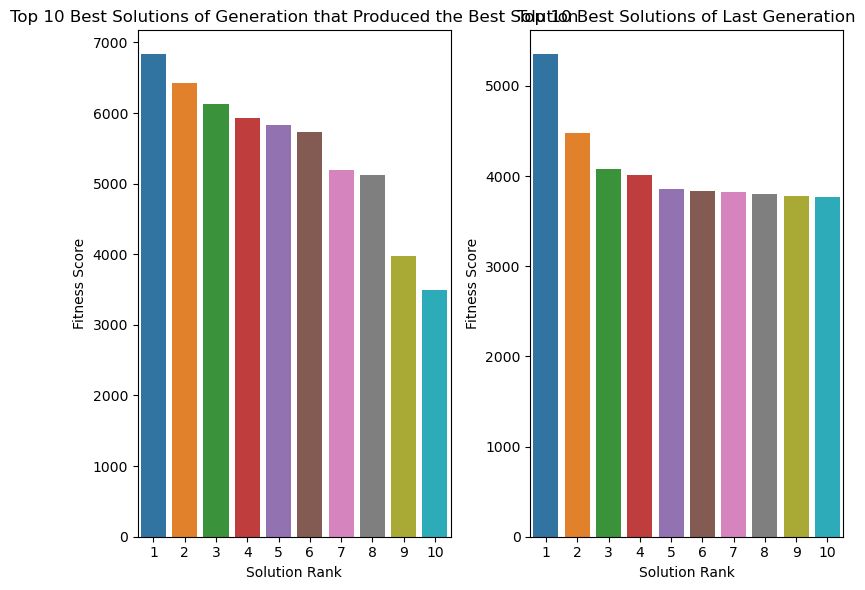

In [7]:
# Best solutions analysis (top 10) 

# best overall top 10 fitness values
best_solutions_df = pd.DataFrame({
    'Rank': range(1, len(top_10_fitness_values) + 1),
    'Fitness': top_10_fitness_values
})

plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)

sns.barplot(data=best_solutions_df, x='Rank', y='Fitness')
plt.xlabel('Solution Rank')
plt.ylabel('Fitness Score')
plt.title('Top 10 Best Solutions of Generation that Produced the Best Solution') # in 'Best' Population

# best top 10 fitness values of last generation
best_solutions_df = pd.DataFrame({
    'Rank': range(1, len(best_fitness_values) + 1),
    'Fitness': best_fitness_values
})

plt.subplot(1, 2, 2)
sns.barplot(data=best_solutions_df, x='Rank', y='Fitness')
plt.xlabel('Solution Rank')
plt.ylabel('Fitness Score')
plt.title('Top 10 Best Solutions of Last Generation')

plt.tight_layout()
plt.show()


In [8]:
# Display best performance metrics
print("\nBest Agent Performance:")
print(f"Highest Score Achieved: {max(results['top_10_fitness_values'])}")
print(f"Average Score of Top 10 Agents in 'Best' Population: {np.mean(results['top_10_fitness_values']):.2f}")
print(f"Standard Deviation of Top 10 Scores in 'Best' Population: {np.std(results['top_10_fitness_values']):.2f}")

# print(data[['Generation', 'Avg Time Taken (s)', 'Max Time Taken (s)']].head())


# top_10_fitness_values
# best_fitness_values


Best Agent Performance:
Highest Score Achieved: 6830.0
Average Score of Top 10 Agents in 'Best' Population: 5464.00
Standard Deviation of Top 10 Scores in 'Best' Population: 998.37


In [9]:
# Calculate and display improvement metrics
improvement_metrics = pd.DataFrame({
    'Metric': [
        'Total Fitness Improvement',
        'Improvement Factor',
        'Average Improvement per Generation',
        'Best Generation (highest fitness)',
        'Generations to 90% of Max',
    ],
    'Value': [
        generation_data['Max Fitness'].max() - generation_data['Max Fitness'].iloc[0],
        generation_data['Max Fitness'].max() / generation_data['Max Fitness'].iloc[0],
        (generation_data['Max Fitness'].max() - generation_data['Max Fitness'].iloc[0]) / len(generation_data),
        generation_data.loc[generation_data['Max Fitness'].idxmax(), 'Generation'],
        generation_data[generation_data['Max Fitness'] >= 0.9 * generation_data['Max Fitness'].max()]['Generation'].iloc[0]
    ]
})

improvement_metrics

,Metric,Value
0,Total Fitness Improvement,5080.000000
1,Improvement Factor,3.902857
2,Average Improvement per Generation,5.080000
3,Best Generation (highest fitness),906.000000
4,Generations to 90% of Max,660.000000


# Video play and stats of best agent

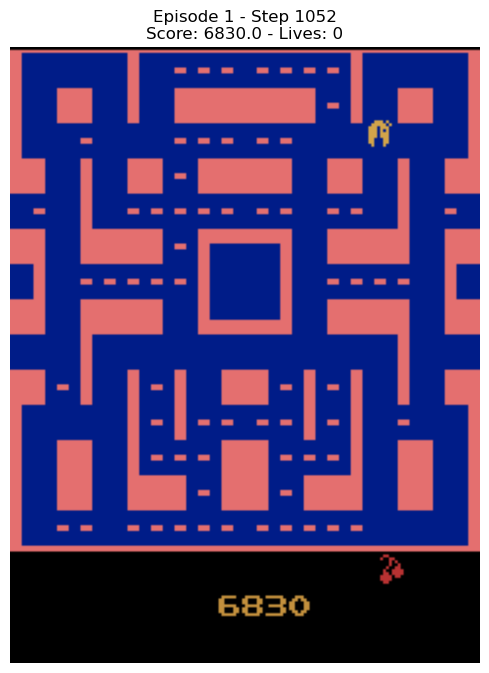


Episode 1 Statistics:
Score: 6830.0
Steps: 1053
Final Lives: 0
Total Frames: 4209
Seed: 322591


In [13]:
# Function to visualise best agent's gameplay with enhanced statistics

def visualise_best_agent(n_episodes=1):
    base_env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
    best_individual = results['best_individual']
    best_seed = results['best_seed']
    
    env = RecordEpisodeStatistics(base_env)
    LIMITED_ACTIONS = [1, 2, 3, 4]  # UP, RIGHT, LEFT, DOWN
    
    # Initialise statistics tracking
    specific_keys = ['lives', 'episode_frame_number', 'frame_number']
    episode_stats = []
    
    for episode in range(n_episodes):
        observation, info = env.reset(seed=best_seed)
        env.action_space.seed(best_seed)
        total_reward = 0
        steps = 0
        terminated = False
        truncated = False
        episode_info = {key: [] for key in specific_keys}
        
        while not (terminated or truncated):
            # Clear previous frame
            clear_output(wait=True)
            
            # Get action from best individual's genome
            action_idx = best_individual[steps % len(best_individual)] % len(LIMITED_ACTIONS)
            action = LIMITED_ACTIONS[action_idx]  
            
            observation, reward, terminated, truncated, info = env.step(action)
            
            for key in specific_keys:
                if key in info:
                    episode_info[key].append(info[key])
            
            plt.figure(figsize=(8, 8))
            plt.imshow(observation)
            plt.axis('off')
            current_lives = info.get('lives', 'N/A')
            plt.title(f'Episode {episode + 1} - Step {steps}\nScore: {total_reward} - Lives: {current_lives}')
            plt.show()
            
            total_reward += reward
            steps += 1
        
        episode_stats.append({
            'episode': episode + 1,
            'total_reward': total_reward,
            'steps': steps,
            'time': env.time_queue[-1] if len(env.time_queue) > 0 else None,
            'return': env.return_queue[-1] if len(env.return_queue) > 0 else None,
            'length': env.length_queue[-1] if len(env.length_queue) > 0 else None,
            **{key: episode_info[key] for key in specific_keys}
        })
        
        print(f"\nEpisode {episode + 1} Statistics:")
        print(f"Score: {total_reward}")
        print(f"Steps: {steps}")
        print(f"Final Lives: {episode_info['lives'][-1] if episode_info['lives'] else 'N/A'}")
        print(f"Total Frames: {episode_info['frame_number'][-1] if episode_info['frame_number'] else 'N/A'}")
        print(f"Seed: {best_seed}")
    
    env.close()
    return pd.DataFrame(episode_stats)

# Visualise the best agent's gameplay and collect statistics
print("\nVisualising Best Agent's Gameplay and Collecting Statistics:")
stats_df = visualise_best_agent(n_episodes=1)

# Display detailed statistics (only for >1 played episodes)
# print("\nDetailed Episode Statistics:")
# print(stats_df.describe())



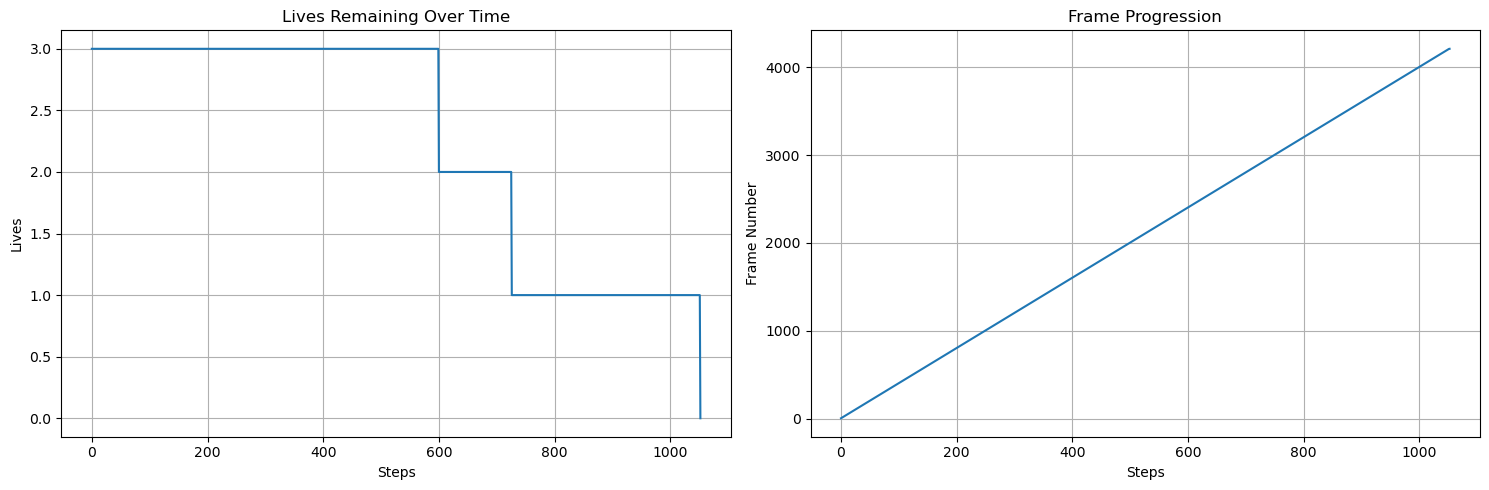

In [14]:
# Create additional visualisations for episode statistics
plt.figure(figsize=(15, 5))

# Plot lives over time for the last episode
if not stats_df.empty and len(stats_df.iloc[0]['lives']) > 0:
    plt.subplot(1, 2, 1)
    plt.plot(stats_df.iloc[0]['lives'])
    plt.title('Lives Remaining Over Time')
    plt.xlabel('Steps')
    plt.ylabel('Lives')
    plt.grid(True)

# Plot frame progression
if not stats_df.empty and len(stats_df.iloc[0]['episode_frame_number']) > 0:
    plt.subplot(1, 2, 2)
    plt.plot(stats_df.iloc[0]['episode_frame_number'])
    plt.title('Frame Progression')
    plt.xlabel('Steps')
    plt.ylabel('Frame Number')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
# Save the video with ffmpeg

# Set the correct path to ffmpeg
os.environ["IMAGEIO_FFMPEG_EXE"] = "/opt/homebrew/bin/ffmpeg"

def play_best_agent_with_video(agent, video_dir="/Users/catherineiwata/Desktop/Final_Project/code_folder/multi_processing/videos", render=False, delay=0.025):
    # Ensure the video directory exists
    os.makedirs(video_dir, exist_ok=True)
    best_seed = results['best_seed']
    LIMITED_ACTIONS = [1, 2, 3, 4]  # NOOP, UP, RIGHT, LEFT, DOWN

    # Create a temporary environment that uses rgb_array for video recording
    tmp_env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
    
    # Wrap the environment in RecordVideo
    env = RecordVideo(env=tmp_env, video_folder=video_dir, name_prefix="best_agent_from_script", episode_trigger=lambda x: x == 0)
    
    env = RecordEpisodeStatistics(env)
    
    # Reset the environment for a fresh start
    observation, info = env.reset(seed=best_seed)
    env.action_space.seed(best_seed)

    total_reward = 0
    terminated = False
    steps = 0
    
    start_time = time.time()  # Track the real start time for the episode

    # Play the game with the best agent's action sequence
    while not terminated:
        if render:
            env.render()  # Render for real-time visualisation
            time.sleep(delay)  # Delay for easier viewing (does not affect time_queue)

        # Get action from best individual's genome
        action_idx = best_individual[steps % len(best_individual)] % len(LIMITED_ACTIONS)
        action = LIMITED_ACTIONS[action_idx]  
        
        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1
        
#         specific_keys = ['lives', 'episode_frame_number', 'frame_number']
#         for key in specific_keys:
#             if key in info:
#                 print(f"{key}: {info[key]}")

        if terminated or truncated:
            observation, info = env.reset()

    # Calculate the real time taken based on the start time
    real_time_taken = time.time() - start_time

    # Close the environment (video will be saved automatically)
    env.close()

    print(f"Total Reward: {total_reward}")
    print(f"Video saved in {video_dir}")
    print(f"Real Episode time taken: {real_time_taken} seconds")  # Real time taken
    print(f'Episode time taken (env): {env.time_queue}')  # Actual time recorded by the environment
    print(f'Episode total rewards: {env.return_queue}')
    print(f'Episode lengths: {env.length_queue}')
    print("Info keys:", info.keys())
    
    specific_keys = ['lives', 'episode_frame_number', 'frame_number']
    for key in specific_keys:
        if key in info:
            print(f"{key}: {info[key]}")
    
# Where 'best_individual' is the best individual
play_best_agent_with_video(best_individual, video_dir="/Users/catherineiwata/Desktop/Final_Project/code_folder/multi_processing/videos", render=True, delay=0.025)

Total Reward: 6830.0
Video saved in /Users/catherineiwata/Desktop/Final_Project/code_folder/multi_processing/videos
Real Episode time taken: 33.048567056655884 seconds
Episode time taken (env): deque([32.71388], maxlen=100)
Episode total rewards: deque([6830.0], maxlen=100)
Episode lengths: deque([1053], maxlen=100)
Info keys: dict_keys(['lives', 'episode_frame_number', 'frame_number'])
lives: 3
episode_frame_number: 0
frame_number: 4209


# Best agent's gameplay and performance over several random episodes

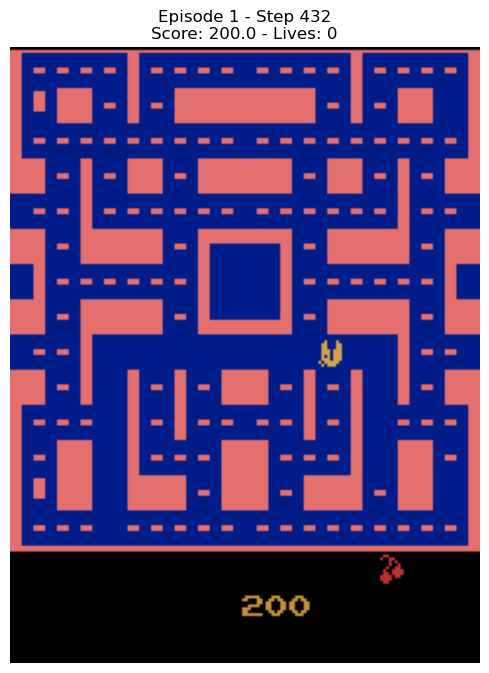


Episode 1 Complete:
Score: 200.0
Steps: 433
Final Lives: 0
Total Frames: 1729

Episode 2 Complete:
Score: 2150.0
Steps: 861
Final Lives: 0
Total Frames: 5170

Episode 3 Complete:
Score: 870.0
Steps: 795
Final Lives: 0
Total Frames: 8347

Episode 4 Complete:
Score: 2470.0
Steps: 1075
Final Lives: 0
Total Frames: 12644

Episode 5 Complete:
Score: 2860.0
Steps: 1011
Final Lives: 0
Total Frames: 16685

Episode 6 Complete:
Score: 1350.0
Steps: 863
Final Lives: 0
Total Frames: 20134

Episode 7 Complete:
Score: 550.0
Steps: 591
Final Lives: 0
Total Frames: 22495

Episode 8 Complete:
Score: 3640.0
Steps: 789
Final Lives: 0
Total Frames: 25648

Episode 9 Complete:
Score: 2460.0
Steps: 865
Final Lives: 0
Total Frames: 29105

Episode 10 Complete:
Score: 2350.0
Steps: 849
Final Lives: 0
Total Frames: 32498


In [16]:
# Function to visualise best agent's gameplay random seed over several episodes with enhanced statistics

def visualise_best_agent(n_episodes=10, display_gameplay=True):  
    base_env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
    env = RecordEpisodeStatistics(base_env)
    best_individual = results['best_ind']
    
    # Initialise statistics tracking
    specific_keys = ['lives', 'episode_frame_number', 'frame_number']
    episode_stats = []
    
    for episode in range(n_episodes):
        observation, info = env.reset()
        total_reward = 0
        steps = 0
        terminated = False
        truncated = False
        episode_info = {key: [] for key in specific_keys}
        
        while not (terminated or truncated):
            # Only display gameplay for the first episode if display_gameplay is True
            if display_gameplay and episode == 0:
                clear_output(wait=True)
            
            # Get action from best individual's genome
            action_idx = best_individual[steps % len(best_individual)] % 4
            action = [1, 2, 3, 4][action_idx]
            
            # Take step and record info
            observation, reward, terminated, truncated, info = env.step(action)
            
            # Record specific information
            for key in specific_keys:
                if key in info:
                    episode_info[key].append(info[key])
            
            # Only display frame for first episode if display_gameplay is True
            if display_gameplay and episode == 0:
                plt.figure(figsize=(8, 8))
                plt.imshow(observation)
                plt.axis('off')
                current_lives = info.get('lives', 'N/A')
                plt.title(f'Episode {episode + 1} - Step {steps}\nScore: {total_reward} - Lives: {current_lives}')
                plt.show()
            
            total_reward += reward
            steps += 1
        
        # Calculate episode statistics
        final_lives = episode_info['lives'][-1] if episode_info['lives'] else None
        total_frames = episode_info['frame_number'][-1] if episode_info['frame_number'] else None
        
        # Collect episode statistics
        episode_stats.append({
            'episode': episode + 1,
            'total_reward': total_reward,
            'steps': steps,
            'time': env.time_queue[-1] if len(env.time_queue) > 0 else None,
            'return': env.return_queue[-1] if len(env.return_queue) > 0 else None,
            'length': env.length_queue[-1] if len(env.length_queue) > 0 else None,
            'final_lives': final_lives,
            'total_frames': total_frames,
            'avg_frames_per_step': total_frames/steps if total_frames else None
        })
        
        print(f"\nEpisode {episode + 1} Complete:")
        print(f"Score: {total_reward}")
        print(f"Steps: {steps}")
        print(f"Final Lives: {final_lives}")
        print(f"Total Frames: {total_frames}")
    
    env.close()
    return pd.DataFrame(episode_stats)

# Run multiple episodes and collect statistics
print("\nRunning Multiple Episodes for Statistical Analysis...")
stats_df = visualise_best_agent(n_episodes=10, display_gameplay=True)



Detailed Episode Statistics:
        episode  total_reward        steps       time       return  \
count  10.00000     10.000000    10.000000  10.000000    10.000000   
mean    5.50000   1890.000000   813.200000   2.575364  1890.000000   
std     3.02765   1101.897354   185.961645   7.549454  1101.897354   
min     1.00000    200.000000   433.000000   0.125587   200.000000   
25%     3.25000    990.000000   790.500000   0.179391   990.000000   
50%     5.50000   2250.000000   855.000000   0.186147  2250.000000   
75%     7.75000   2467.500000   864.500000   0.216446  2467.500000   
max    10.00000   3640.000000  1075.000000  24.061320  3640.000000   

            length  final_lives  total_frames  avg_frames_per_step  
count    10.000000         10.0     10.000000            10.000000  
mean    813.200000          0.0  17445.500000            21.458760  
std     185.961645          0.0  10363.611139            13.396828  
min     433.000000          0.0   1729.000000             3.993

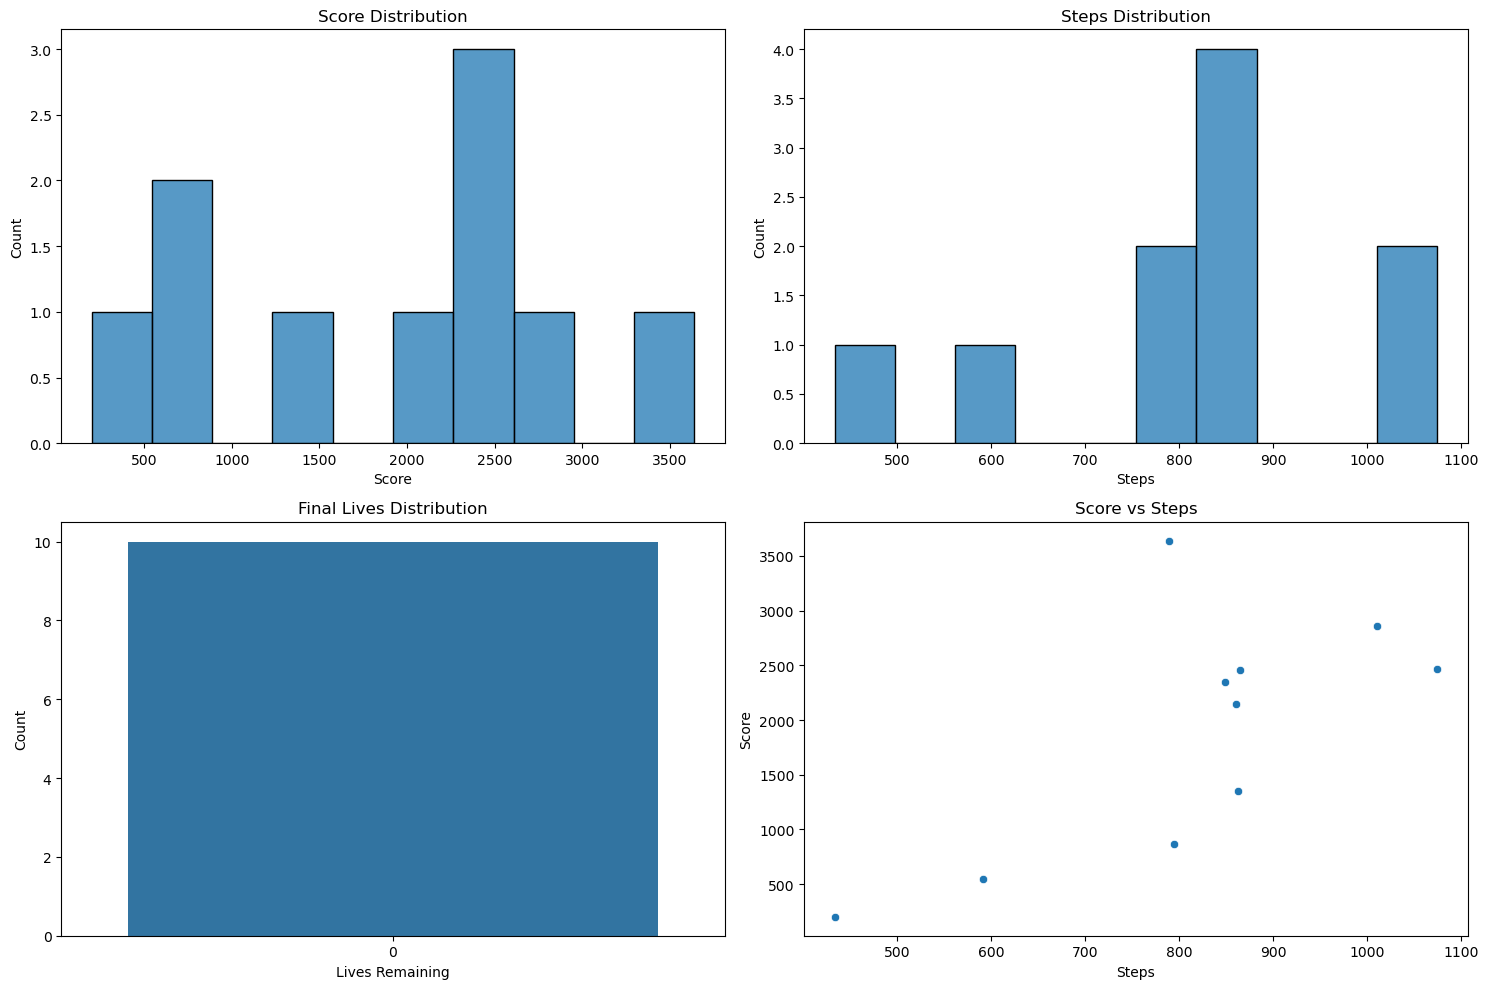


Performance Summary:
Average Score: 1890.00 ± 1101.90
Average Steps: 813.20 ± 185.96
Average Final Lives: 0.00 ± 0.00

Best Episode:
Score: 3640.0
Steps: 789.0
Final Lives: 0.0


In [17]:
# Display detailed statistics
print("\nDetailed Episode Statistics:")
print(stats_df.describe())

# Create additional statistical visualizations
plt.figure(figsize=(15, 10))

# Score distribution
plt.subplot(2, 2, 1)
sns.histplot(data=stats_df, x='total_reward', bins=10)
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count')

# Steps distribution
plt.subplot(2, 2, 2)
sns.histplot(data=stats_df, x='steps', bins=10)
plt.title('Steps Distribution')
plt.xlabel('Steps')
plt.ylabel('Count')

# Final lives distribution
plt.subplot(2, 2, 3)
sns.countplot(data=stats_df, x='final_lives')
plt.title('Final Lives Distribution')
plt.xlabel('Lives Remaining')
plt.ylabel('Count')

# Score vs Steps scatter plot
plt.subplot(2, 2, 4)
sns.scatterplot(data=stats_df, x='steps', y='total_reward')
plt.title('Score vs Steps')
plt.xlabel('Steps')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Display summary statistics
print("\nPerformance Summary:")
print(f"Average Score: {stats_df['total_reward'].mean():.2f} ± {stats_df['total_reward'].std():.2f}")
print(f"Average Steps: {stats_df['steps'].mean():.2f} ± {stats_df['steps'].std():.2f}")
print(f"Average Final Lives: {stats_df['final_lives'].mean():.2f} ± {stats_df['final_lives'].std():.2f}")
print(f"\nBest Episode:")
best_episode = stats_df.loc[stats_df['total_reward'].idxmax()]
print(f"Score: {best_episode['total_reward']}")
print(f"Steps: {best_episode['steps']}")
print(f"Final Lives: {best_episode['final_lives']}")

# # Save the enhanced statistics to CSV
# stats_df.to_csv('best_agent_detailed_stats.csv', index=False)
# print("\nDetailed statistics have been saved to 'best_agent_detailed_stats.csv'")

# Enhanced Statistical Analysis and Visualisations

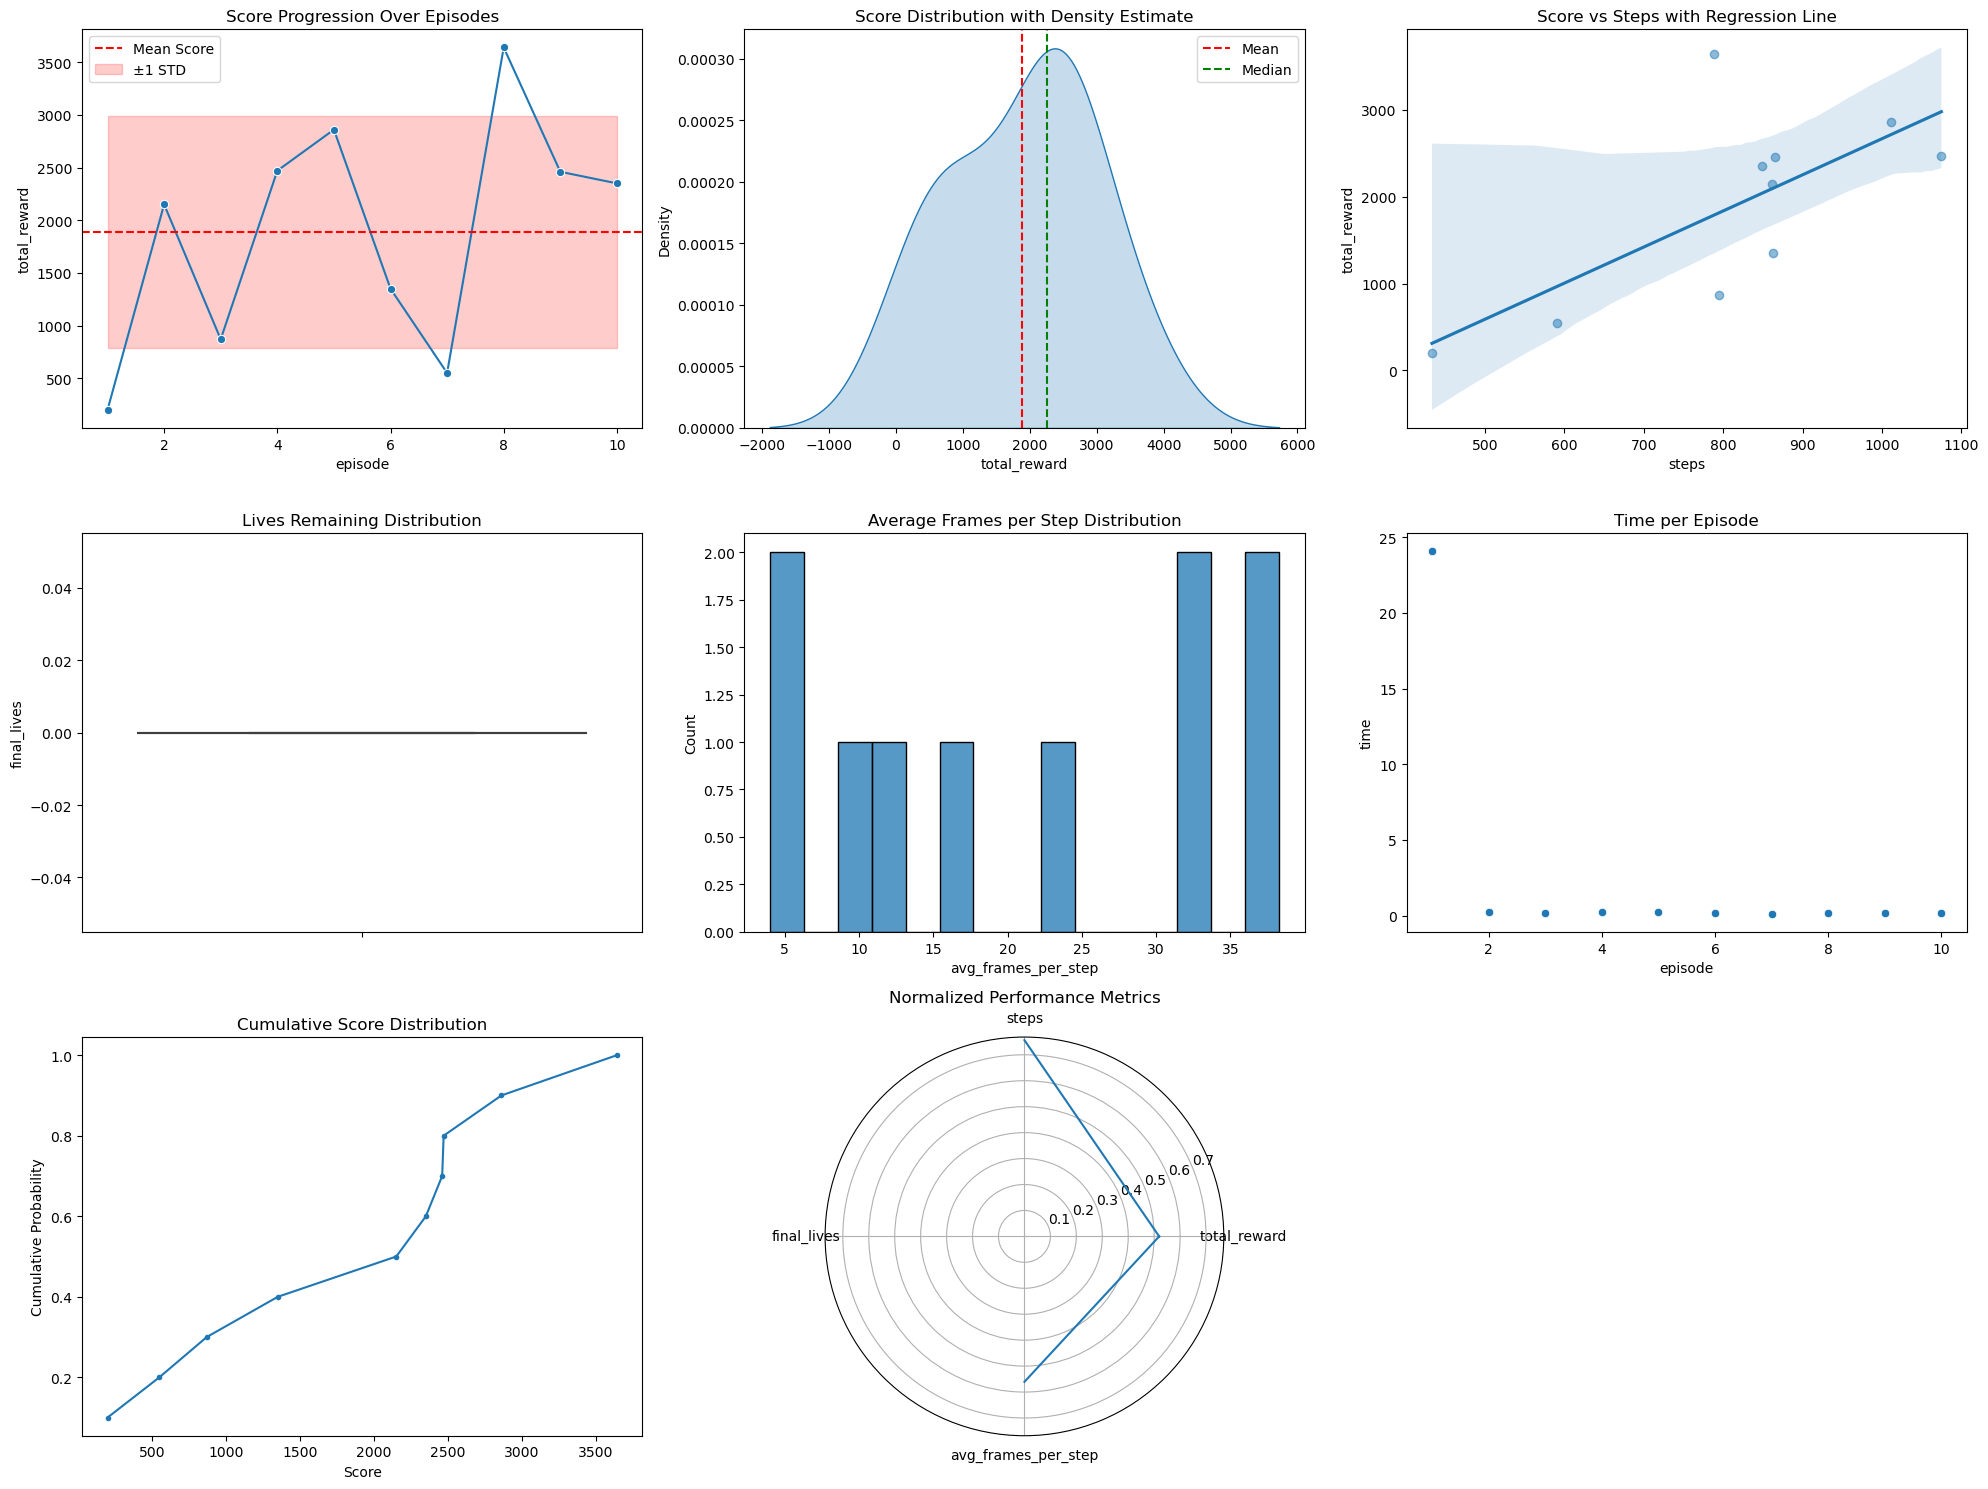

In [18]:
# Enhanced Statistical Analysis and Visualisations
# Comprehensive performance 
fig = plt.figure(figsize=(20, 15))

# 1. Score progression over episodes
plt.subplot(3, 3, 1)
sns.lineplot(data=stats_df, x='episode', y='total_reward', marker='o')
plt.axhline(y=stats_df['total_reward'].mean(), color='r', linestyle='--', label='Mean Score')
plt.fill_between(stats_df['episode'], 
                 stats_df['total_reward'].mean() - stats_df['total_reward'].std(),
                 stats_df['total_reward'].mean() + stats_df['total_reward'].std(),
                 alpha=0.2, color='r', label='±1 STD')
plt.title('Score Progression Over Episodes')
plt.legend()

# 2. Enhanced score distribution
plt.subplot(3, 3, 2)
sns.kdeplot(data=stats_df, x='total_reward', fill=True)
plt.axvline(stats_df['total_reward'].mean(), color='r', linestyle='--', label='Mean')
plt.axvline(stats_df['total_reward'].median(), color='g', linestyle='--', label='Median')
plt.title('Score Distribution with Density Estimate')
plt.legend()

# 3. Steps vs Score with regression line
plt.subplot(3, 3, 3)
sns.regplot(data=stats_df, x='steps', y='total_reward', scatter_kws={'alpha':0.5})
plt.title('Score vs Steps with Regression Line')

# 4. Lives remaining distribution
plt.subplot(3, 3, 4)
sns.boxplot(data=stats_df, y='final_lives')
plt.title('Lives Remaining Distribution')

# 5. Frames per step distribution
plt.subplot(3, 3, 5)
sns.histplot(data=stats_df, x='avg_frames_per_step', bins=15)
plt.title('Average Frames per Step Distribution')

# 6. Time per episode
plt.subplot(3, 3, 6)
sns.scatterplot(data=stats_df, x='episode', y='time', marker='o')
plt.title('Time per Episode')

# 7. Cumulative reward distribution
plt.subplot(3, 3, 7)
sorted_scores = np.sort(stats_df['total_reward'])
cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
plt.plot(sorted_scores, cumulative, marker='.')
plt.title('Cumulative Score Distribution')
plt.xlabel('Score')
plt.ylabel('Cumulative Probability')

# 8. Performance metrics radar chart
plt.subplot(3, 3, 8, projection='polar')
metrics = ['total_reward', 'steps', 'final_lives', 'avg_frames_per_step']
values = [stats_df[metric].mean() / stats_df[metric].max() for metric in metrics]
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False)
values = np.concatenate((values, [values[0]]))  # complete the loop
angles = np.concatenate((angles, [angles[0]]))  # complete the loop
plt.plot(angles, values)
plt.fill(angles, values, alpha=0.25)
plt.xticks(angles[:-1], metrics)
plt.title('Normalised Performance Metrics')

plt.tight_layout()
plt.show()

In [19]:
# Statistical Analysis Summary
print("\nDetailed Statistical Analysis:")
print("\n1. Basic Statistics:")
print(stats_df.describe())

print("\n2. Performance Metrics:")
for metric in ['total_reward', 'steps', 'final_lives', 'total_frames']:
    print(f"\n{metric.replace('_', ' ').title()}:")
    print(f"Mean: {stats_df[metric].mean():.2f}")
    print(f"Median: {stats_df[metric].median():.2f}")
    print(f"Standard Deviation: {stats_df[metric].std():.2f}")
    print(f"Coefficient of Variation: {stats_df[metric].std() / stats_df[metric].mean():.2f}")
    print(f"95% Confidence Interval: ({stats_df[metric].quantile(0.025):.2f}, {stats_df[metric].quantile(0.975):.2f})")

# print("\n3. Correlation Analysis:")
# print(correlation_matrix.round(3))

# Performance consistency analysis
print("\n4. Performance Consistency Analysis:")
consistency_metrics = {
    'Score Consistency': 1 - (stats_df['total_reward'].std() / stats_df['total_reward'].mean()),
    'Steps Consistency': 1 - (stats_df['steps'].std() / stats_df['steps'].mean()),
    'Lives Consistency': 1 - (stats_df['final_lives'].std() / stats_df['final_lives'].mean())
}
for metric, value in consistency_metrics.items():
    print(f"{metric}: {value:.2f}")

# # Time series analysis
# from scipy import stats

print("\n5. Time Series Analysis:")
# Test for trend in scores
slope, intercept, r_value, p_value, std_err = stats.linregress(stats_df['episode'], stats_df['total_reward'])
print(f"Score trend analysis:")
print(f"Slope: {slope:.2f}")
print(f"R-squared: {r_value**2:.2f}")
print(f"P-value: {p_value:.4f}")

# Calculate moving averages
window_size = 3
stats_df['moving_avg_score'] = stats_df['total_reward'].rolling(window=window_size).mean()

print("\n6. Episode Quartile Analysis:")
quartiles = stats_df['total_reward'].quantile([0.25, 0.5, 0.75])
print("\nScore Quartiles:")
print(quartiles)

# # Save enhanced statistics to CSV
# stats_df.to_csv('best_agent_detailed_stats_enhanced.csv', index=False)
# print("\nEnhanced statistics have been saved to 'best_agent_detailed_stats_enhanced.csv'")
 


Detailed Statistical Analysis:

1. Basic Statistics:
        episode  total_reward        steps       time       return  \
count  10.00000     10.000000    10.000000  10.000000    10.000000   
mean    5.50000   1890.000000   813.200000   2.575364  1890.000000   
std     3.02765   1101.897354   185.961645   7.549454  1101.897354   
min     1.00000    200.000000   433.000000   0.125587   200.000000   
25%     3.25000    990.000000   790.500000   0.179391   990.000000   
50%     5.50000   2250.000000   855.000000   0.186147  2250.000000   
75%     7.75000   2467.500000   864.500000   0.216446  2467.500000   
max    10.00000   3640.000000  1075.000000  24.061320  3640.000000   

            length  final_lives  total_frames  avg_frames_per_step  
count    10.000000         10.0     10.000000            10.000000  
mean    813.200000          0.0  17445.500000            21.458760  
std     185.961645          0.0  10363.611139            13.396828  
min     433.000000          0.0   1729.